In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import imageio

In [2]:
import glob
eva=[]
for image_path in glob.glob("image_aumentation/Eva/*.jpg"):
    image = imageio.imread(image_path)
    eva.append(image)

In [3]:
len(eva)

70

In [4]:
import glob
edgar=[]
for image_path in glob.glob("image_aumentation/Edgar/*.jpg"):
    image = imageio.imread(image_path)
    edgar.append(image)

In [5]:
eva_res=[]
width = 224
height = 224
for image in eva:
    image_resized = cv2.resize(image,(width,height),interpolation = cv2.INTER_CUBIC)
    eva_res.append(image_resized)

In [6]:
edgar_res=[]
width = 224
height = 224
for image in edgar:
    image_resized = cv2.resize(image,(width,height),interpolation = cv2.INTER_CUBIC)
    edgar_res.append(image_resized)

In [7]:
edited_eva=[]
for i in range(len(eva_res)):
    gray_eva= cv2.cvtColor(eva_res[i],cv2.COLOR_BGR2GRAY)
    edges = cv2.adaptiveThreshold(gray_eva, 255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,27,10)
    color_eva= cv2.cvtColor(edges,cv2.COLOR_GRAY2RGB)
    edited_eva.append(color_eva)

In [8]:
edited_edgar=[]
for i in range(len(eva_res)):
    gray_eva= cv2.cvtColor(edgar_res[i],cv2.COLOR_BGR2GRAY)
    edges = cv2.adaptiveThreshold(gray_eva, 255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,27,10)
    color_edgar= cv2.cvtColor(edges,cv2.COLOR_GRAY2RGB)
    edited_edgar.append(color_edgar)

### Pre-pocesat imatges

In [9]:
eva = np.asarray(edited_eva)

In [10]:
edgar = np.asarray(edited_edgar)

### Train/test

In [11]:
total = eva.shape[0]

In [12]:
train = total*0.8
train

56.0

In [13]:
eva = np.split(eva,[56])

In [14]:
edgar = np.split(edgar,[56])


In [15]:
eva_train = eva[0]
eva_test = eva[1]

In [16]:
edgar_train = edgar[0]
edgar_test = edgar[1]

In [17]:
label_eva_train=np.zeros((56))
label_eva_test=np.zeros((14))
#We define that if we have a 0 is a Eva

In [18]:
label_edgar_train=np.ones((56))
label_edgar_test=np.ones((14))

In [19]:
eva_train.shape

(56, 224, 224, 3)

In [20]:
edgar_train.shape

(56, 224, 224, 3)

In [21]:
train_x=np.concatenate((eva_train,edgar_train))
test_x=np.concatenate((eva_test,edgar_test))
train_y=np.concatenate((label_eva_train,label_edgar_train))
test_y=np.concatenate((label_eva_test,label_edgar_test))

## MODEL

In [22]:
image_size = 224
#ESTO NO DEBE DE ESTAR AQUI

In [23]:
import tensorflow as tf
from tensorflow import keras
IMG_SHAPE = (image_size, image_size,3)
#This is the size of the images in the input


# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


W0829 08:51:38.303551 140535234881344 deprecation.py:506] From /home/eva/anaconda3/envs/akademyai/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
base_model.trainable = False

In [25]:
model = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(485, activation='elu'),
    keras.layers.Flatten(data_format=None),
    keras.layers.Dense(1, activation='sigmoid')
])


In [26]:
# We need to compile the model before train it
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


W0829 08:51:44.410520 140535234881344 deprecation.py:323] From /home/eva/anaconda3/envs/akademyai/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## AQUI ES DONDE ENTRENAMOS EL MODELO DEFINIDO ANTERIORMENTE CON NUESTROS DATOS

In [27]:
model.fit(train_x, train_y, epochs=7)

Epoch 1/7
112/112 [==============================] - 12s 107ms/sample - loss: 0.6446 - acc: 0.6071
Epoch 2/7
112/112 [==============================] - 11s 96ms/sample - loss: 0.5950 - acc: 0.6875
Epoch 3/7
112/112 [==============================] - 11s 96ms/sample - loss: 0.5601 - acc: 0.7054
Epoch 4/7
112/112 [==============================] - 11s 94ms/sample - loss: 0.5397 - acc: 0.7589
Epoch 5/7
112/112 [==============================] - 10s 86ms/sample - loss: 0.5167 - acc: 0.7946
Epoch 6/7
112/112 [==============================] - 10s 88ms/sample - loss: 0.4780 - acc: 0.8571
Epoch 7/7
112/112 [==============================] - 10s 87ms/sample - loss: 0.4753 - acc: 0.8214


In [35]:
# evaluate
test_loss, test_acc = model.evaluate(test_x, test_y)
print('test accuracy: ', test_acc)

28/28 [==============================] - 2s 63ms/sample - loss: 0.8621 - acc: 0.5000
test accuracy:  0.5


In [29]:
# evaluate model
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8621001839637756
Test accuracy: 0.5


In [30]:
predictions = model.predict(test_x)

In [31]:
predictions[0][0]

0.24236262

In [32]:
print('x_test shape: ', test_x.shape)
x_test_plt = np.squeeze(test_x)
print('x_test_plt shape: ', x_test_plt.shape)
print('predictions: ', predictions.shape)

x_test shape:  (28, 224, 224, 3)
x_test_plt shape:  (28, 224, 224, 3)
predictions:  (28, 1)


Prediction:  ['Eva']
With an accuracy of: 50.0 %


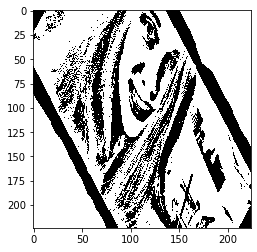

In [33]:
 #see results
i = 1
plt.imshow(x_test_plt[i])
print('Prediction: ' , np.where(predictions[i]<=0.5,'Eva','Edgar'))
print('With an accuracy of:', np.round(score[1]*100,2), '%' )

Si la Eva es 0 i Edgar es 1 fem que si es mes gran

In [36]:
cap = cv2.VideoCapture(0)
from PIL import ImageFont, ImageDraw, Image
# Load our image template, this is our reference image
image_template = cv2.imread('eva2.jpeg', 0) 

while True:

    # Get webcam images
    ret, frame = cap.read()
    
    img = np.resize(frame, (224,224,3))
    im2arr = np.array(img)
    im2arr1 = im2arr.reshape(1,224,224,3)
    predictions = model.predict(im2arr1)
    if predictions < 0.3:
        text = "EVA"
    if predictions > 0.7:
        text = "EDGAR"
    else:
        text = " "
    
    cv2.putText(frame,text,(30,70), cv2.FONT_HERSHEY_COMPLEX, 2 ,(255,255,255), 6)
    #cv2.putText(frame,predictions[0][0],(150,150), cv2.FONT_HERSHEY_COMPLEX, 2 ,(0,255,0), 2)
    cv2.imshow('Object Detector using ORB', frame)
    
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break

cap.release()
cv2.destroyAllWindows()